<a href="https://colab.research.google.com/github/RayGone/CottonWeeds/blob/main/Mobilenet/V3S/GA/_Experiment-2.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cottonweed15-downsampled:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5048236%2F8510416%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T011355Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D01e75ad6f7f14e30dd0546e50d96da043782fef679e3bbdf2d034f94412d3e23d34c10acdcbe8b735b027cb15d6687f29a6d6ef9706fa3e41858f64f4bc32aa787d756f4410f53a4aa150ae42b7e41ad9e6eb05be140542e1eee80bc7e8c5aee1b8e27f783ea3cfe9411d417a438a6dfd9bb1b258de2b660ad7f1532c287a7c17468dea0401c23df3b927630dc7b1c90ac0510d575511b9e1552b65abb36281f02cdcdd4bbcefe5fbf218558ac71932b8d226d8ec932ed290feb74147a090abe100fef356724a8d9137238e6743064c79f058864fe595f83703593539321cc2d7e7883570ea8bd0884fd64e01ae2a8f7578b247ab41ed202e7aeb7d6f51c9e28'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 331375564 bytes downloaded
Downloaded and uncompressed: cottonweed15-downsampled
Data source import complete.


# CottonWeed15 - MobileNetV3Small

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        print("Running Deterministically")
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed)

In [3]:
# ! pip install kagglehub --upgrade --q

# import kagglehub
# print(kagglehub.__version__)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("kaggle_token")

# kagglehub.auth.set_kaggle_credentials('reganmaharjan',key)

In [4]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [5]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/cottonweed15-downsampled/labels.csv") ## For Kaggle
data_info = data_info[['img', 'label']]
data_info

img     label
0     351b9a52aaaf40f592557cca89a902a5__nutsedge__0.jpg  Nutsedge
1     992b7dca6928459e85aafbf945585dd0__nutsedge__7.jpg  Nutsedge
2     8803be5e86774ff1b7116d5f5a5b2727__nutsedge__0.jpg  Nutsedge
3     e1da7a5e314a41c5886b384bd69320fc__nutsedge__0.jpg  Nutsedge
4                                          IMG_0547.JPG  Nutsedge
...                                                 ...       ...
5182  1f101adc29984ee783d36d96ad6e5b7d__purselane__2...  Purslane
5183                                           0001.jpg  Purslane
5184                                       IMG_1426.JPG  Purslane
5185                                   IMG_1481 (3).JPG  Purslane
5186                                   IMG_2097 (3).JPG  Purslane

[5187 rows x 2 columns]

In [6]:
label_counts = data_info.groupby('label').count()
label_counts.T

label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            763        111      254         216          1115       273   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               689           129       450      129        240   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              234            61          72        451

In [7]:
# label2id = data_info['label'].unique()
# label2id = {label2id[i]:i for i in range(len(label2id))}
# id2label = {label2id[i]:i for i in label2id}
label2id = {'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3,
            'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7,
            'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11,
            'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
id2label = {label2id[i]:i for i in label2id}
labels = [id2label[i] for i in range(len(label2id))]
print(id2label)
print(label2id)
print(labels)

{0: 'Nutsedge', 1: 'Sicklepod', 2: 'Morningglory', 3: 'Ragweed', 4: 'PalmerAmaranth', 5: 'Waterhemp', 6: 'Crabgrass', 7: 'Swinecress', 8: 'Prickly Sida', 9: 'Carpetweeds', 10: 'SpottedSpurge', 11: 'SpurredAnoda', 12: 'Eclipta', 13: 'Goosegrass', 14: 'Purslane'}
{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']


In [8]:
data_info['img'] = data_info.apply(lambda x: str(label2id[x['label']])+"_"+x['img'], axis=1)
data_info['id'] = data_info.apply(lambda x: label2id[x['label']], axis=1)

In [9]:
threshold = label_counts.quantile(0.25).iloc[0]
print(threshold)

low_data_labels = label_counts[label_counts['img'] <= threshold] ## labels with very low data
print(low_data_labels.T)
low_data_labels = list(low_data_labels.T.keys())
low_data_labels

129.0
label  Crabgrass  Prickly Sida  Ragweed  SpurredAnoda  Swinecress
img          111           129      129            61          72


['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [10]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 0 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

skfold = StratifiedKFold(shuffle=True, random_state=seed)
kSplits = skfold.split(data_info['img'], y=data_info['label'])

for index in range(skfold.get_n_splits()):
    train_index, test_index = next(kSplits)
    if index == split_index:
        break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 1 out of 5 folds
-------------------------------------------------



In [11]:
train_data = data_info.iloc[train_index]
test_data = data_info.iloc[test_index]

print("Is There Duplicates: ", not test_data[test_data['img'].isin(train_data['img'])].empty)
print("Train Data\n-----------------------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("||\nTest Data\n-------------------------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
-----------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            610         89      203         173           892       218   
id             610         89      203         173           892       218   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               551           103       360      103        192   
id                551           103       360      103        192   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              187            49          58        361  
id               187            49          58        361   	Total: (4149, 3)
||
Test Data
-------------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            153         22       51          43           223        55   
id             153         22       51          43           223        55   

label  PalmerAmarant

## Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [12]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['img']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]

    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Creating Dateset ImageGenerator

In [14]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/cottonweed15-downsampled/img" ## For Kaggle
base_dir = "/kaggle/working/cottonweed15" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
train_generator, validation_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      class_names=labels,
      image_size = IMG_SIZE[:2],
      shuffle=True,
      seed=seed,
      validation_split=0.25,
      subset="both"
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      class_names=labels,
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 4149 files belonging to 15 classes.
Using 3112 files for training.
Using 1037 files for validation.
Found 1038 files belonging to 15 classes.


In [42]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="label", orig_from_paper=False):
    orig = {0: 5.72, 1: 4.65, 2: 1.4, 3: 8.64, 4: 2.27, 5: 3.46, 6: 10.05, 7: 15.49, 8: 8.64, 9: 2.05, 10: 4.77, 11: 18.28, 12: 4.39, 13: 5.16, 14: 3.47}
    if(orig_from_paper):
        return {i: j/10 for i,j in orig.items()}

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

### Displaying Images

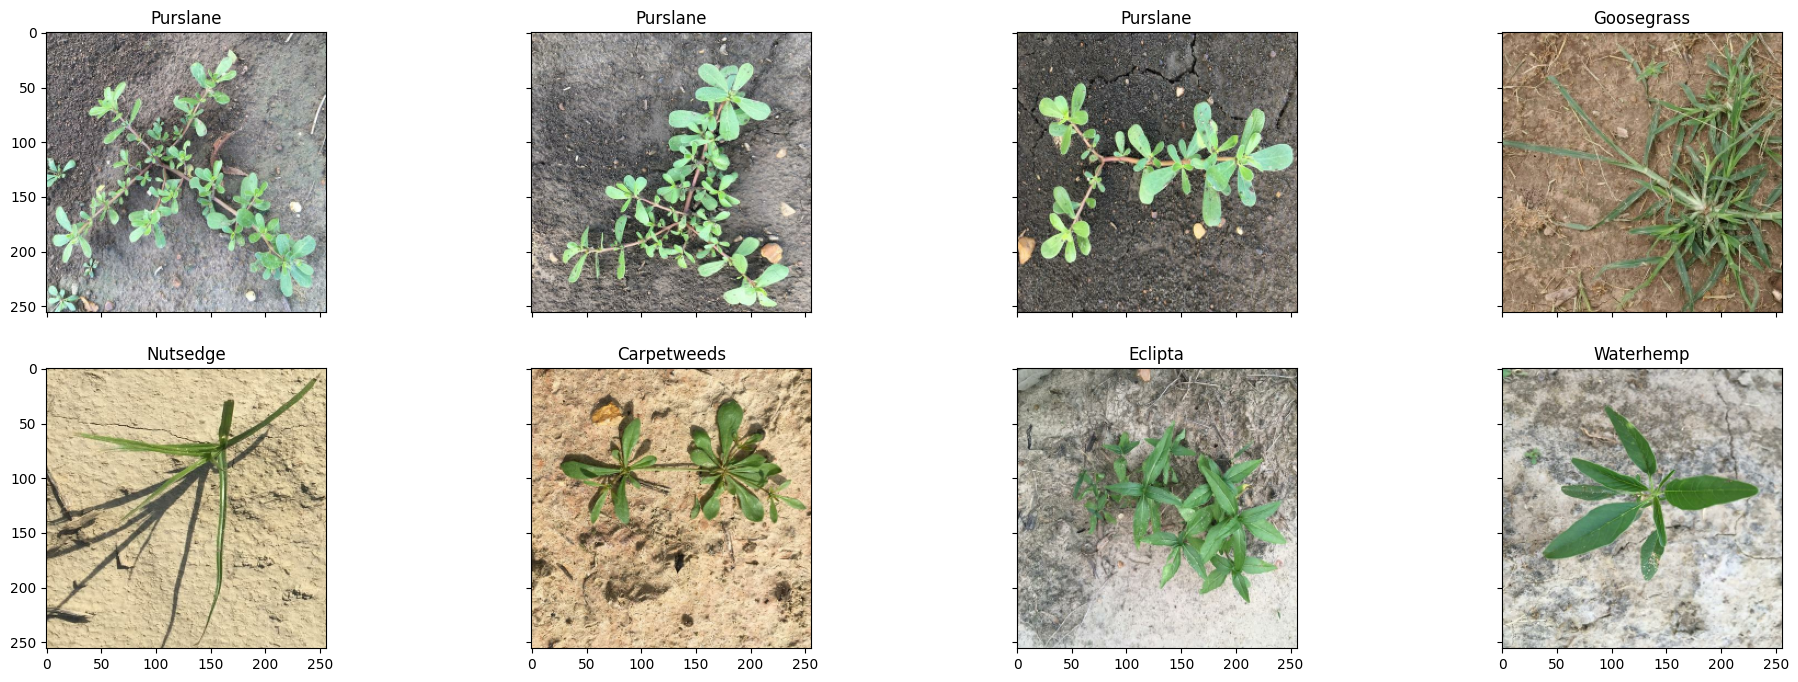

In [17]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# Pooling Schemes

In [18]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

# Transformer Encoder: Global Self Attention & Point-wise Feed Forward

In [19]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Building MobileNet Model

In [76]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.2, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.2, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.3, 0.3, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.1, 0.1, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')

class ImageNormalize(layers.Layer):
    def __init__(self, mean=0.5, std=0.5, **kwargs):
        super(ImageNormalize,self).__init__(**kwargs)
        self.mean = mean
        self.std = std
        # perm = (0, 3, 1, 2)

    def call(self, x, training=True):
        x = (x - self.mean) / self.std
        # x = tf.transpose(x, perm=perm)
        return x

def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def buildModel(train=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model = MobileNetV3Small(input_shape=(224,224,3), weights='imagenet', include_top=False)
    base_model.trainable = train

    print("Base Model:", base_model.name)

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Resizing(224, 224, name='PP_Resize')(inputs)
    x = layers.Rescaling(1./255, name='PP_Rescale')(x)
    x = ImageNormalize(name="PP_Normalize")(x)

    x = augment(seed)(x)
    # Pass the input through the pre-trained InceptionV3 model.
    x = base_model(x, training=train)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(15, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name.upper()
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [77]:
# IMG_SIZE = (256,256,3)
# seed = 42

model = buildModel(True)
model.summary()

Base Model: MobilenetV3small
Model: "CottonWeed15-MOBILENETV3SMALL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 PP_Rescale (Rescaling)      (None, 224, 224, 3)       0         
                                                                 
 PP_Normalize (ImageNormali  (None, 224, 224, 3)       0         
 ze)                                                             
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 Mobilen

In [78]:
# keras.utils.plot_model(model)

## Trial 1 - FineTuning

In [79]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])


# print(label_counts.to_dict()['img'])
print(label2id)
weights = getWeightedClass(data_info, 0.9, 'id')
weights

{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}


{0: 1.2370752203572368,
 1: 1.3891603292219072,
 2: 0.34865436712471587,
 3: 2.428911833706478,
 4: 0.5377063810197326,
 5: 0.7873785915498897,
 6: 2.7806850959757066,
 7: 4.105284346389431,
 8: 2.428911833706478,
 9: 0.49053545842050145,
 10: 1.421177157147302,
 11: 4.765907824029004,
 12: 1.3200553606531649,
 13: 1.527334331667958,
 14: 0.7889531739023736}

Epoch 1/100
98/98 [==============================] - 39s 153ms/step - loss: 2.4749 - accuracy: 0.1726 - val_loss: 2.1264 - val_accuracy: 0.3269 - lr: 2.0000e-04
Epoch 2/100
98/98 [==============================] - 13s 124ms/step - loss: 1.8343 - accuracy: 0.3483 - val_loss: 1.6597 - val_accuracy: 0.4764 - lr: 2.0000e-04
Epoch 3/100
98/98 [==============================] - 13s 130ms/step - loss: 1.4555 - accuracy: 0.4717 - val_loss: 1.3898 - val_accuracy: 0.5564 - lr: 2.0000e-04
Epoch 4/100
98/98 [==============================] - 13s 124ms/step - loss: 1.2558 - accuracy: 0.5453 - val_loss: 1.1978 - val_accuracy: 0.6297 - lr: 2.0000e-04
Epoch 5/100
98/98 [==============================] - 12s 122ms/step - loss: 1.0716 - accuracy: 0.5980 - val_loss: 1.0698 - val_accuracy: 0.6702 - lr: 2.0000e-04
Epoch 6/100
98/98 [==============================] - 13s 123ms/step - loss: 0.9470 - accuracy: 0.6359 - val_loss: 0.9518 - val_accuracy: 0.6962 - lr: 2.0000e-04
Epoch 7/100
98/98 [===============

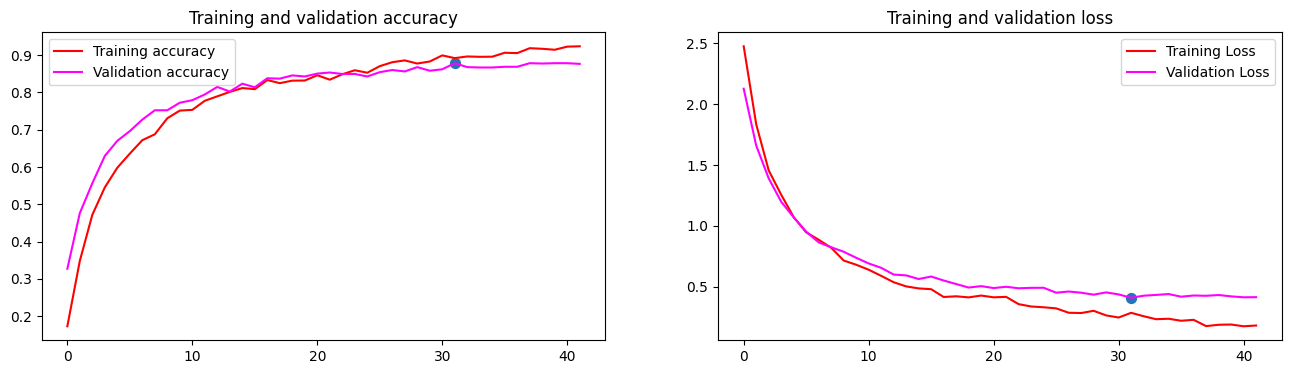

CPU times: user 14min 9s, sys: 41 s, total: 14min 50s
Wall time: 12min 14s


In [80]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
      class_weight=weights,
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
33/33 [==============================] - 2s 66ms/step - loss: 0.4092 - accuracy: 0.8785
model.predict


  0%|          | 0/33 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.83636   0.95833   0.89320        48
     Sicklepod    0.88636   0.86667   0.87640        45
  Morningglory    0.97608   0.91480   0.94444       223
       Ragweed    0.86957   0.90909   0.88889        22
PalmerAmaranth    0.88591   0.93617   0.91034       141
     Waterhemp    0.76289   0.91358   0.83146        81
     Crabgrass    0.75000   0.71429   0.73171        21
    Swinecress    1.00000   1.00000   1.00000        13
  Prickly Sida    0.89474   0.60714   0.72340        28
   Carpetweeds    0.93919   0.89103   0.91447       156
 SpottedSpurge    0.82979   0.79592   0.81250        49
  SpurredAnoda    0.70588   1.00000   0.82759        12
       Eclipta    0.86000   0.75439   0.80374        57
    Goosegrass    0.82927   0.80952   0.81928        42
      Purslane    0.80000   0.84848   0.82353        99

      accuracy                        0.87850      1037
     macro avg    0.85507 

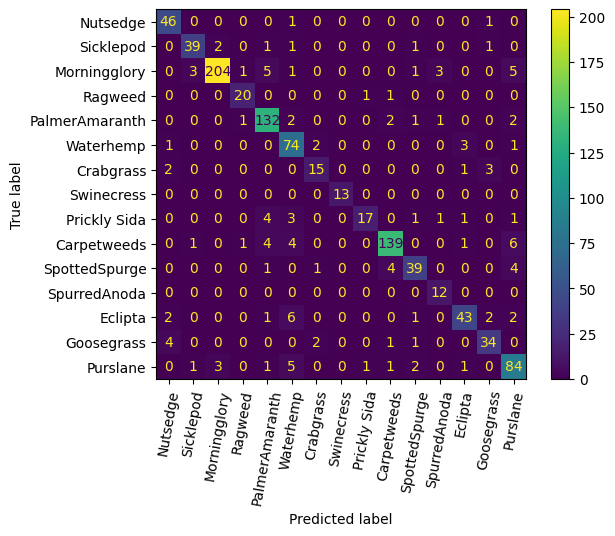

In [81]:
a, b = eval_model(model, validation_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small
Epoch 1/100
98/98 [==============================] - 16s 103ms/step - loss: 3.1604 - accuracy: 0.0797 - val_loss: 2.7061 - val_accuracy: 0.1128 - lr: 1.0000e-04
Epoch 2/100
98/98 [==============================] - 11s 105ms/step - loss: 2.8754 - accuracy: 0.0813 - val_loss: 2.5857 - val_accuracy: 0.1244 - lr: 1.0000e-04
Epoch 3/100
98/98 [==============================] - 11s 103ms/step - loss: 2.7954 - accuracy: 0.0803 - val_loss: 2.5597 - val_accuracy: 0.1504 - lr: 1.0000e-04
Epoch 4/100
98/98 [==============================] - 9s 91ms/step - loss: 2.7447 - accuracy: 0.0823 - val_loss: 2.5623 - val_accuracy: 0.1437 - lr: 1.0000e-04
Epoch 5/100
98/98 [==============================] - 10s 98ms/step - loss: 2.7216 - accuracy: 0.0868 - val_loss: 2.5633 - val_accuracy: 0.1514 - lr: 1.0000e-04
Epoch 6/100
98/98 [==============================] - ETA: 0s - loss: 2.6886 - accuracy: 0.0890
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e

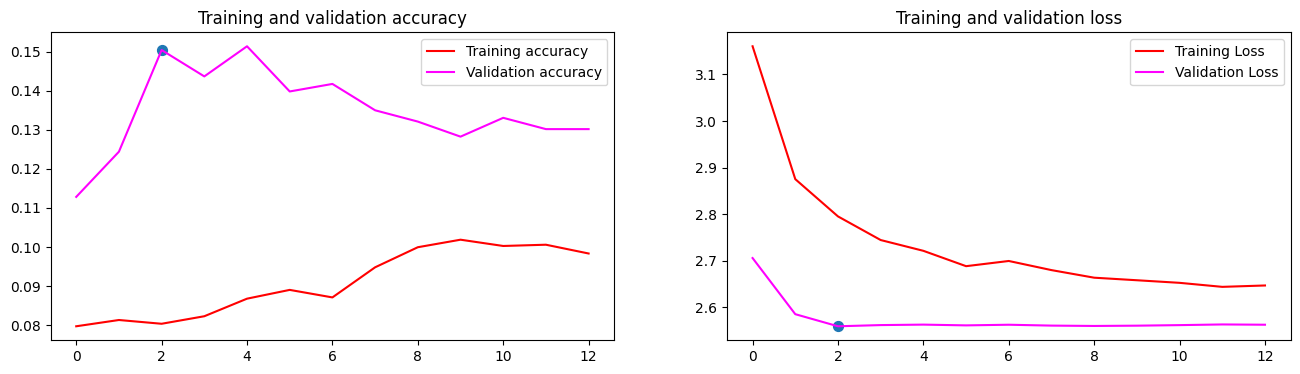

CPU times: user 3min 32s, sys: 12.2 s, total: 3min 44s
Wall time: 3min 10s


In [82]:
%%time
# model = skipAugment(model)
for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-4,  weight_decay=2e-2),
  metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-8)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
      class_weight=weights,
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

## Evaluations

Total Epochs: range(0, 55)


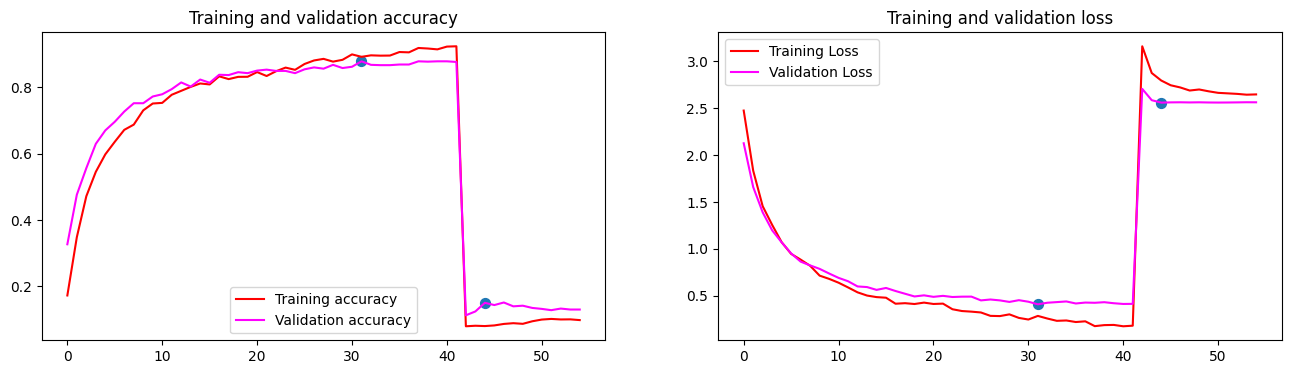

In [83]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 42)


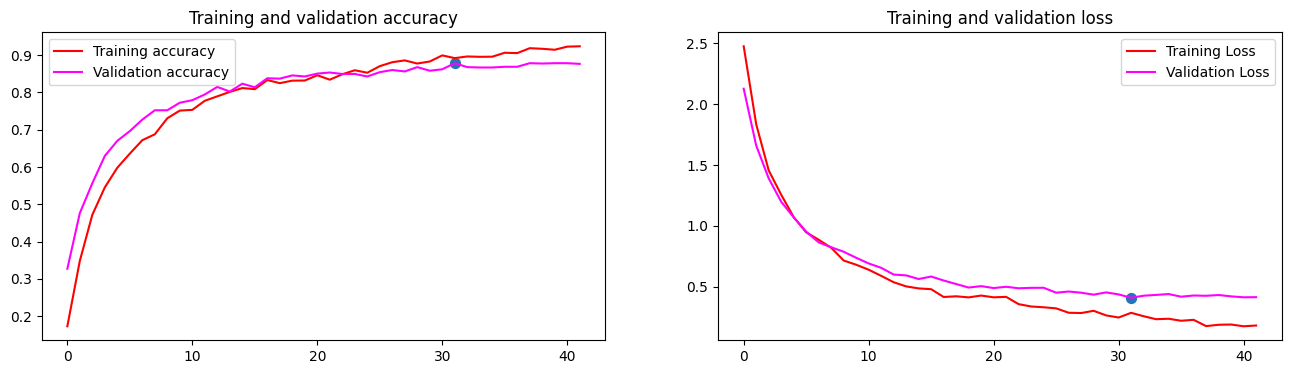

Total Epochs: range(0, 13)


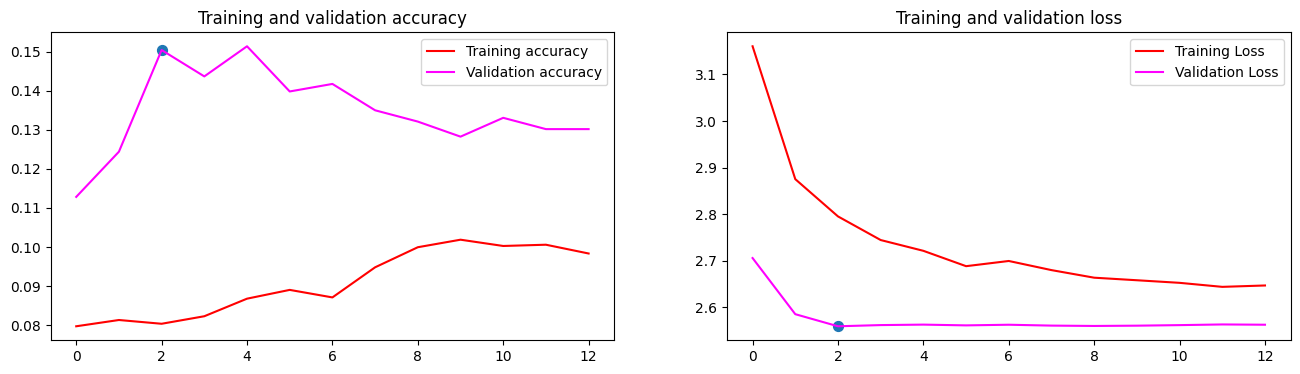

In [84]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
33/33 [==============================] - 2s 65ms/step - loss: 2.5597 - accuracy: 0.1504
model.predict


  0%|          | 0/33 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.07925   0.43750   0.13419        48
     Sicklepod    0.01818   0.02222   0.02000        45
  Morningglory    0.21331   0.48879   0.29700       223
       Ragweed    0.00000   0.00000   0.00000        22
PalmerAmaranth    0.24528   0.09220   0.13402       141
     Waterhemp    0.30000   0.11111   0.16216        81
     Crabgrass    0.00000   0.00000   0.00000        21
    Swinecress    0.00000   0.00000   0.00000        13
  Prickly Sida    0.00000   0.00000   0.00000        28
   Carpetweeds    0.15385   0.01282   0.02367       156
 SpottedSpurge    0.00000   0.00000   0.00000        49
  SpurredAnoda    0.00000   0.00000   0.00000        12
       Eclipta    0.00000   0.00000   0.00000        57
    Goosegrass    0.01333   0.02381   0.01709        42
      Purslane    0.00000   0.00000   0.00000        99

      accuracy                        0.15043      1037
     macro avg    0.06821 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


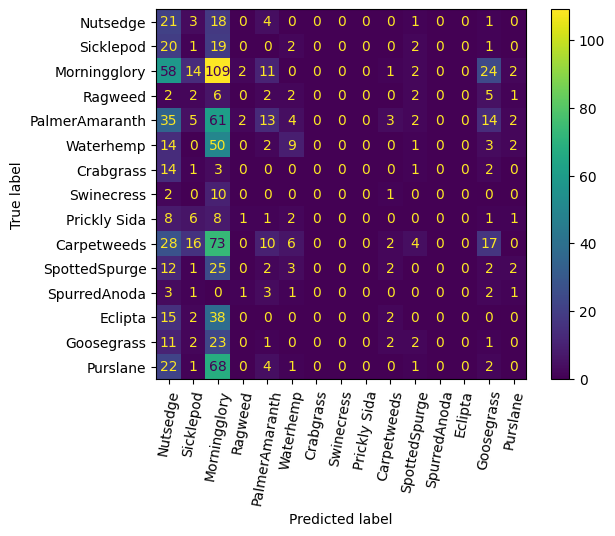

In [85]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

### Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
65/65 [==============================] - 2s 37ms/step - loss: 2.5416 - accuracy: 0.1590
model.predict


  0%|          | 0/65 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.11905   0.54545   0.19544        55
     Sicklepod    0.01471   0.02083   0.01724        48
  Morningglory    0.22465   0.50673   0.31129       223
       Ragweed    0.00000   0.00000   0.00000        26
PalmerAmaranth    0.22034   0.09420   0.13198       138
     Waterhemp    0.20000   0.07778   0.11200        90
     Crabgrass    0.00000   0.00000   0.00000        22
    Swinecress    0.00000   0.00000   0.00000        14
  Prickly Sida    0.00000   0.00000   0.00000        26
   Carpetweeds    0.16667   0.00654   0.01258       153
 SpottedSpurge    0.00000   0.00000   0.00000        47
  SpurredAnoda    0.00000   0.00000   0.00000        12
       Eclipta    0.00000   0.00000   0.00000        51
    Goosegrass    0.00000   0.00000   0.00000        43
      Purslane    0.00000   0.00000   0.00000        90

      accuracy                        0.15896      1038
     macro avg    0.06303 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


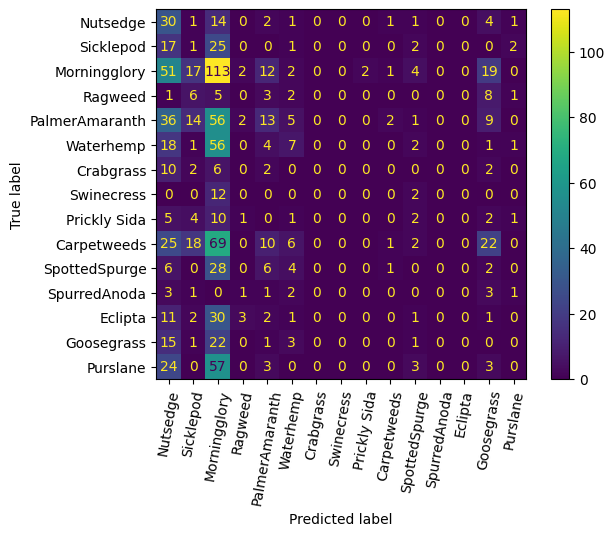

In [86]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

In [ ]:
shutil.rmtree(base_dir)